In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import re #to handle regular expression when replacing
#let's import a library do deal with stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#needed for ex3 e)
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, confusion_matrix

# Start by loading the data set (train.csv)
df = pd.read_csv('train.csv')

# Print train.csv
print(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


             ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0      65087372        10000          32236             12329.36286    59   
1       1450153         3609          11940             12191.99692    59   
2       1969101        28276           9311             21603.22455    59   
3       6651430        11170           6954             17877.15585    59   
4      14354669        16890          13226             13539.92667    59   
...         ...          ...            ...                     ...   ...   
67458  16164945        13601           6848             13175.28583    59   
67459  35182714         8323          11046             15637.46301    59   
67460  16435904        15897          32921             12329.45775    59   
67461   5300325        16567           4975             21353.68465    59   
67462  65443173        15353          29875             14207.44860    59   

      Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ..

In [2]:
# 1. Data Exploration and Preparation

# There is an error in two columns in the data set, so we need to fix it
# We need to switch the columns 'Employment Duration' and 'Home Ownership'
print("O data set antes da troca é: \n" )

print(df['Employment Duration'].head())
print(df['Home Ownership'].head())

df['Employment Duration'], df['Home Ownership'] = df['Home Ownership'], df['Employment Duration']

print("\nO data set depois da troca é: \n" )

print(df['Employment Duration'].head())
print(df['Home Ownership'].head())

O data set antes da troca é: 

0    MORTGAGE
1        RENT
2    MORTGAGE
3    MORTGAGE
4    MORTGAGE
Name: Employment Duration, dtype: object
0    176346.62670
1     39833.92100
2     91506.69105
3    108286.57590
4     44234.82545
Name: Home Ownership, dtype: float64

O data set depois da troca é: 

0    176346.62670
1     39833.92100
2     91506.69105
3    108286.57590
4     44234.82545
Name: Employment Duration, dtype: float64
0    MORTGAGE
1        RENT
2    MORTGAGE
3    MORTGAGE
4    MORTGAGE
Name: Home Ownership, dtype: object


In [3]:
# Remove some columns
df = df.drop(columns = ['ID', 'Payment Plan', 'Accounts Delinquent'])
print(df)

       Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0            10000          32236             12329.36286    59   
1             3609          11940             12191.99692    59   
2            28276           9311             21603.22455    59   
3            11170           6954             17877.15585    59   
4            16890          13226             13539.92667    59   
...            ...            ...                     ...   ...   
67458        13601           6848             13175.28583    59   
67459         8323          11046             15637.46301    59   
67460        15897          32921             12329.45775    59   
67461        16567           4975             21353.68465    59   
67462        15353          29875             14207.44860    59   

      Batch Enrolled  Interest Rate Grade Sub Grade  Employment Duration  \
0         BAT2522922      11.135007     B        C4         176346.62670   
1         BAT1586599      12.237563     C  

In [4]:
# Number of rows
linhas = len(df)
print("Number of rows: " + str(linhas))

# Number of collumns
colunas = len(df.columns)
print("Number of columns: " + str(colunas))

# Collumns Names
col_names = df.columns
print(col_names)

Number of rows: 67463
Number of columns: 32
Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Loan Title', 'Debit to Income', 'Delinquency - two years',
       'Inquires - six months', 'Open Account', 'Public Record',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')


In [5]:
# View the first rows of the data set and then the last rows
first = df.head()
last = df.tail()
print("The first rows are:\n" + str(first) + "\n The last rows are: \n" + str(last))

The first rows are:
   Loan Amount  Funded Amount  Funded Amount Investor  Term Batch Enrolled  \
0        10000          32236             12329.36286    59     BAT2522922   
1         3609          11940             12191.99692    59     BAT1586599   
2        28276           9311             21603.22455    59     BAT2136391   
3        11170           6954             17877.15585    59     BAT2428731   
4        16890          13226             13539.92667    59     BAT5341619   

   Interest Rate Grade Sub Grade  Employment Duration Home Ownership  ...  \
0      11.135007     B        C4         176346.62670       MORTGAGE  ...   
1      12.237563     C        D3          39833.92100           RENT  ...   
2      12.545884     F        D4          91506.69105       MORTGAGE  ...   
3      16.731201     C        C3         108286.57590       MORTGAGE  ...   
4      15.008300     C        D4          44234.82545       MORTGAGE  ...   

  Total Received Late Fee   Recoveries  Collecti

In [6]:
# Data exploration
# Size
size = df.size
print('O tamanho do data set é: ' + str(size))

# Get a Summary of Data
describe = df.describe()
print("\n"+ str(describe))



O tamanho do data set é: 2158816

        Loan Amount  Funded Amount  Funded Amount Investor          Term  \
count  67463.000000   67463.000000            67463.000000  67463.000000   
mean   16848.902776   15770.599114            14621.799323     58.173814   
std     8367.865726    8150.992662             6785.345170      3.327441   
min     1014.000000    1014.000000             1114.590204     36.000000   
25%    10012.000000    9266.500000             9831.684984     58.000000   
50%    16073.000000   13042.000000            12793.682170     59.000000   
75%    22106.000000   21793.000000            17807.594120     59.000000   
max    35000.000000   34999.000000            34999.746430     59.000000   

       Interest Rate  Employment Duration  Debit to Income  \
count   67463.000000         67463.000000     67463.000000   
mean       11.846258         80541.502522        23.299241   
std         3.718629         45029.120366         8.451824   
min         5.320006         1457

In [7]:
# Check which columns are Numeric and which are Categorical
dtypes = df.dtypes
print("Os data types são: \n" + str(dtypes) )

Os data types são: 
Loan Amount                       int64
Funded Amount                     int64
Funded Amount Investor          float64
Term                              int64
Batch Enrolled                   object
Interest Rate                   float64
Grade                            object
Sub Grade                        object
Employment Duration             float64
Home Ownership                   object
Verification Status              object
Loan Title                       object
Debit to Income                 float64
Delinquency - two years           int64
Inquires - six months             int64
Open Account                      int64
Public Record                     int64
Revolving Balance                 int64
Revolving Utilities             float64
Total Accounts                    int64
Initial List Status              object
Total Received Interest         float64
Total Received Late Fee         float64
Recoveries                      float64
Collection Recovery 

In [8]:
# Check for missing data by rows and by columns
# By rows
missing_rows = df.isnull().any(axis = 1)
print(missing_rows)
dframe_missing_rows = df[missing_rows] # Doesn't have missing rows
print(dframe_missing_rows)

# By columns
columns_with_NaN = df.isnull().sum() # Doesn't have NaN in columns
print(columns_with_NaN)

0        False
1        False
2        False
3        False
4        False
         ...  
67458    False
67459    False
67460    False
67461    False
67462    False
Length: 67463, dtype: bool
Empty DataFrame
Columns: [Loan Amount, Funded Amount, Funded Amount Investor, Term, Batch Enrolled, Interest Rate, Grade, Sub Grade, Employment Duration, Home Ownership, Verification Status, Loan Title, Debit to Income, Delinquency - two years, Inquires - six months, Open Account, Public Record, Revolving Balance, Revolving Utilities, Total Accounts, Initial List Status, Total Received Interest, Total Received Late Fee, Recoveries, Collection Recovery Fee, Collection 12 months Medical, Application Type, Last week Pay, Total Collection Amount, Total Current Balance, Total Revolving Credit Limit, Loan Status]
Index: []

[0 rows x 32 columns]
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled          

In [9]:
# Verify if have duplicate rows
print(size)
df_duplicates = df.drop_duplicates(inplace = True)
print(df.size) # Doesn't have duplicate rows

# Check for unique values
unique_values = df.nunique()
print(unique_values)


2158816


2158816
Loan Amount                     27525
Funded Amount                   24548
Funded Amount Investor          67441
Term                                3
Batch Enrolled                     41
Interest Rate                   67448
Grade                               7
Sub Grade                          35
Employment Duration             67454
Home Ownership                      3
Verification Status                 3
Loan Title                        109
Debit to Income                 67454
Delinquency - two years             9
Inquires - six months               6
Open Account                       36
Public Record                       5
Revolving Balance               20582
Revolving Utilities             67458
Total Accounts                     69
Initial List Status                 2
Total Received Interest         67451
Total Received Late Fee         67380
Recoveries                      67387
Collection Recovery Fee         67313
Collection 12 months Medical        2
Appl

In [10]:
# Get numerical columns
numerical_columns = df.select_dtypes(include = ['int64', 'float64']).columns.tolist()
print("Numerical columns: " + str(numerical_columns))

Numerical columns: ['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Employment Duration', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']


Categorical columns: ['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership', 'Verification Status', 'Loan Title', 'Initial List Status', 'Application Type']


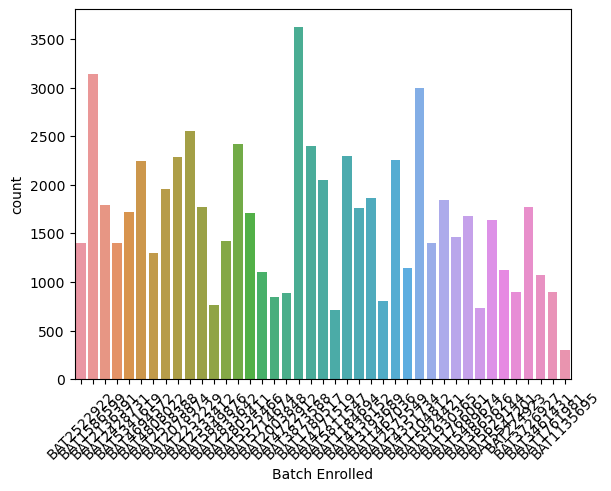

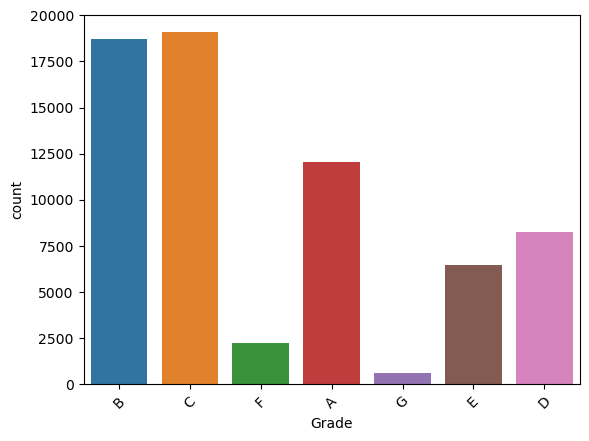

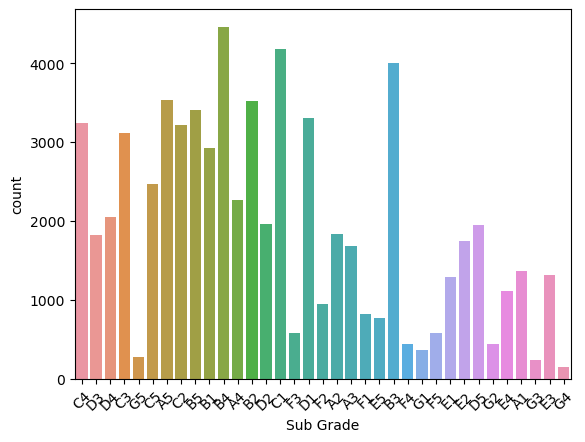

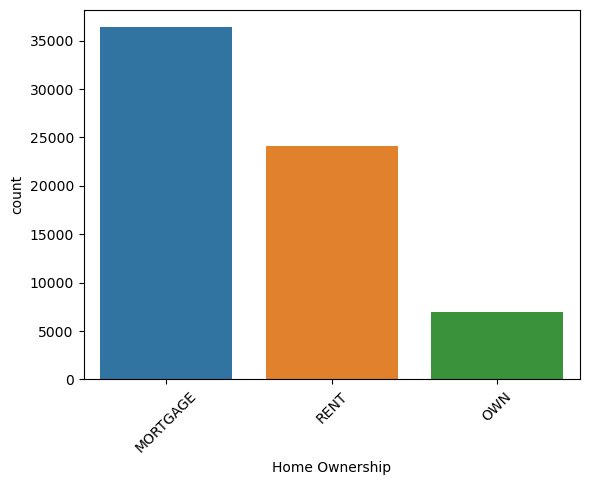

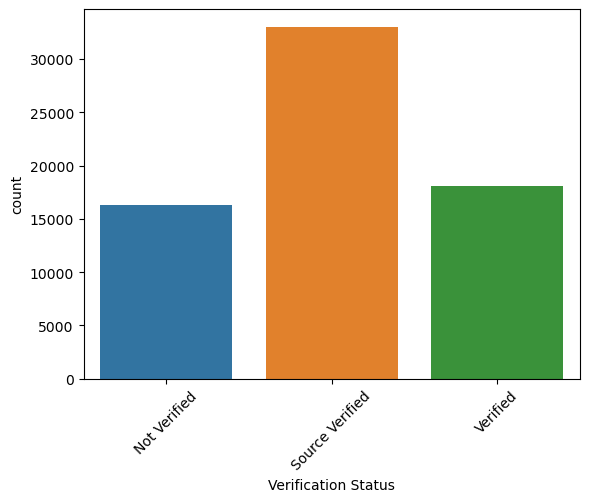

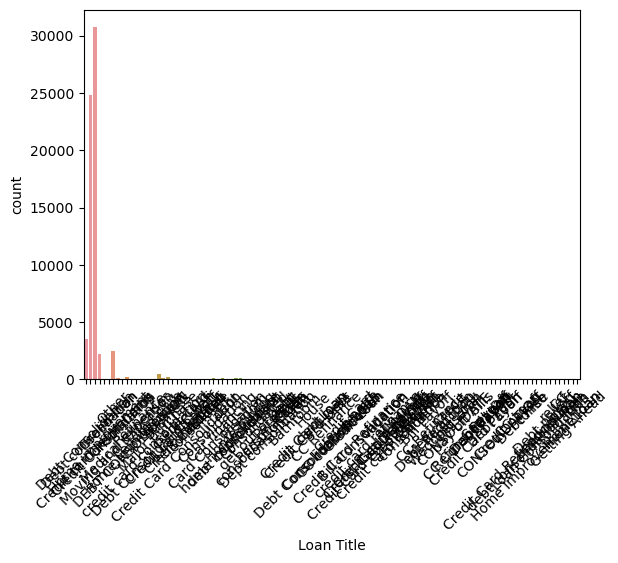

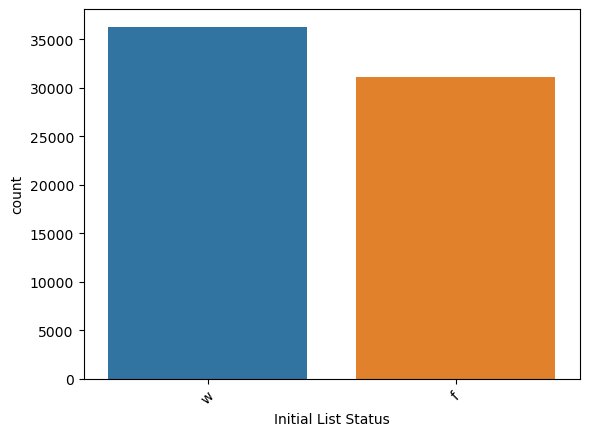

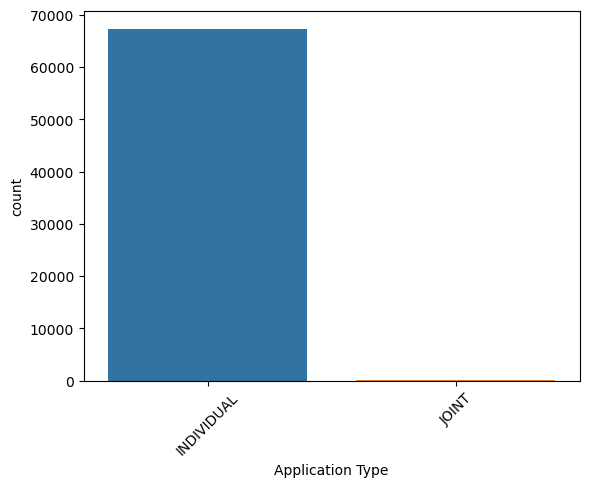

In [11]:
# Get categorical columns
categorical_columns = df.select_dtypes(include = ['object']).columns.tolist()
print("Categorical columns: " + str(categorical_columns))

for column in categorical_columns:
    sns.countplot(data=df, x=column)
    plt.xticks(rotation=45)
    plt.show()
# We can't see very well Batch Enrolled, Sub Grade and Loan Title plots

83


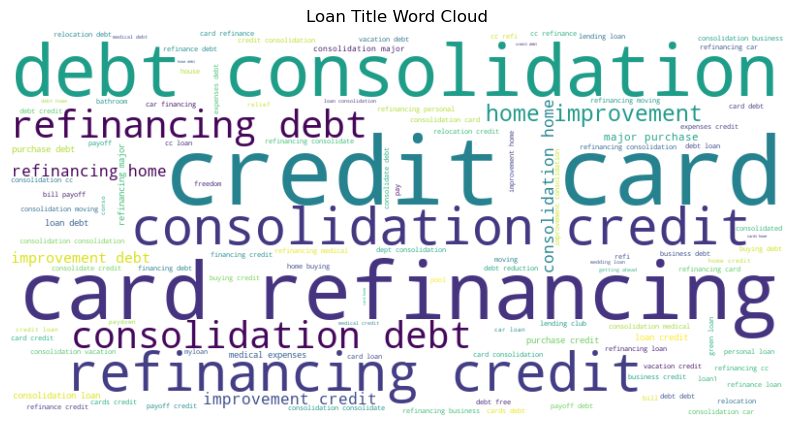

In [12]:
# To Loan Title we use Word Cloud plot
df['Loan Title'] = df['Loan Title'].str.lower()
print(df['Loan Title'].nunique())
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(df['Loan Title']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Loan Title Word Cloud')
plt.show()


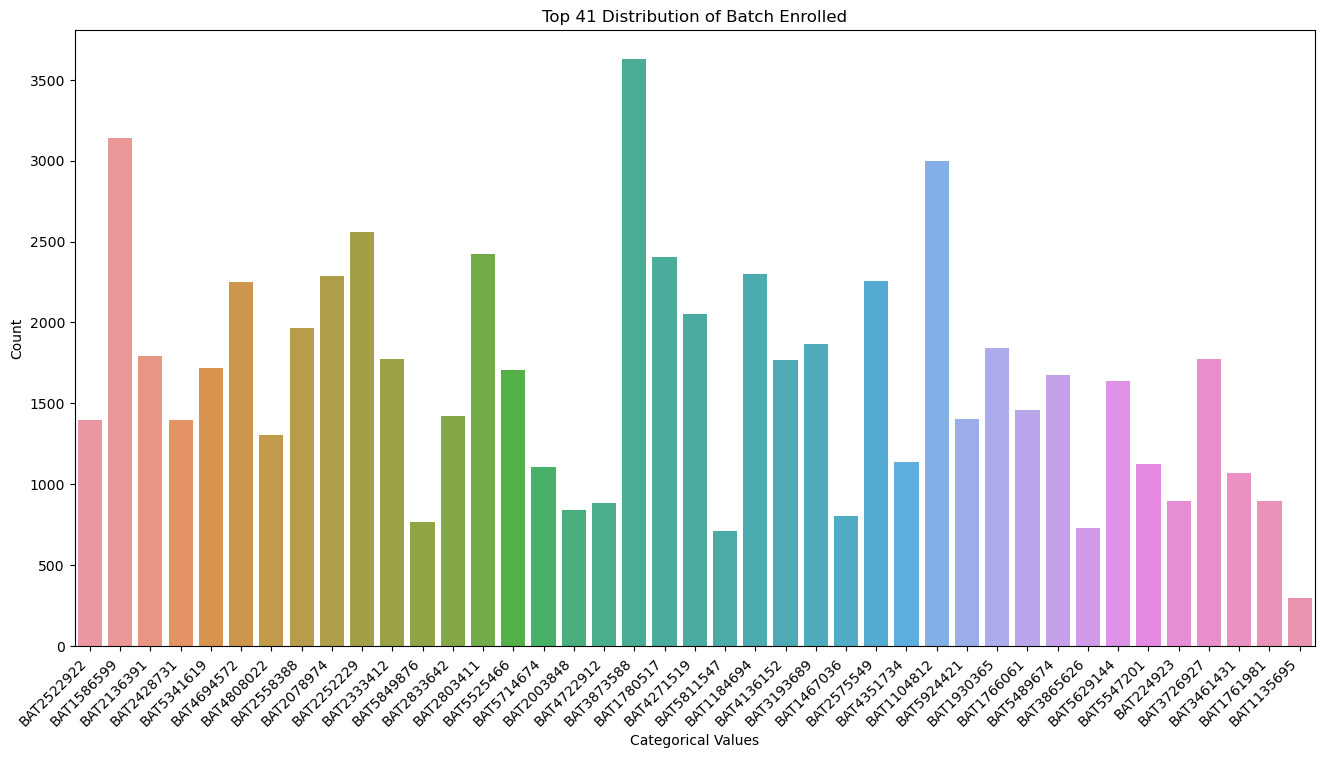

In [13]:
# To column of Batch Enrolled we use Top N Bar Plot
top_n_values = 41
top_values = df['Batch Enrolled'].value_counts().nlargest(top_n_values).index

plt.figure(figsize=(16, 8))
sns.countplot(x='Batch Enrolled', data=df[df['Batch Enrolled'].isin(top_values)])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categorical Values')
plt.ylabel('Count')
plt.title(f'Top {top_n_values} Distribution of Batch Enrolled')
plt.show()

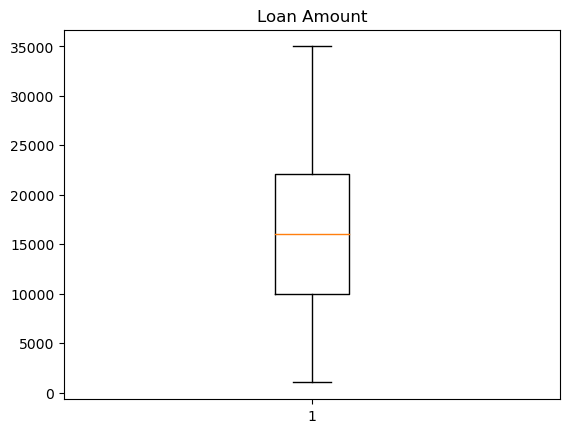

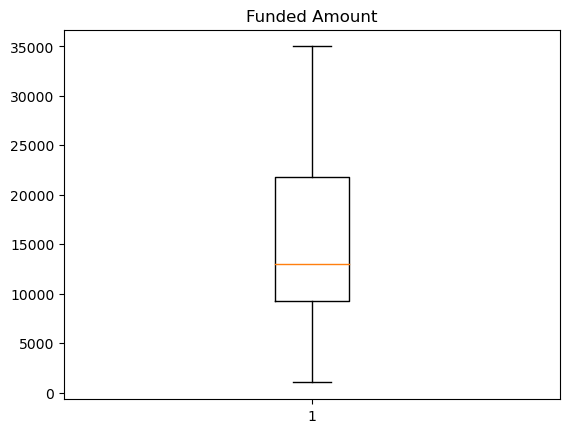

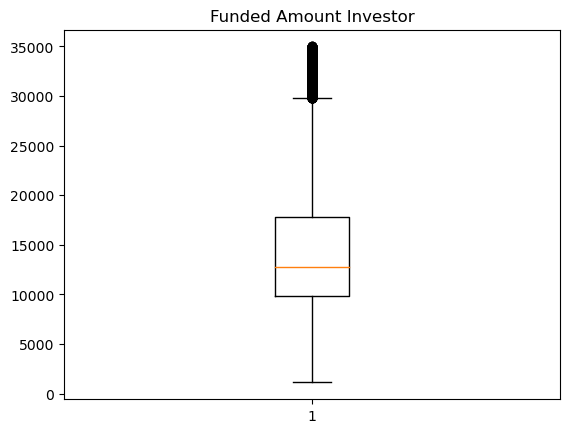

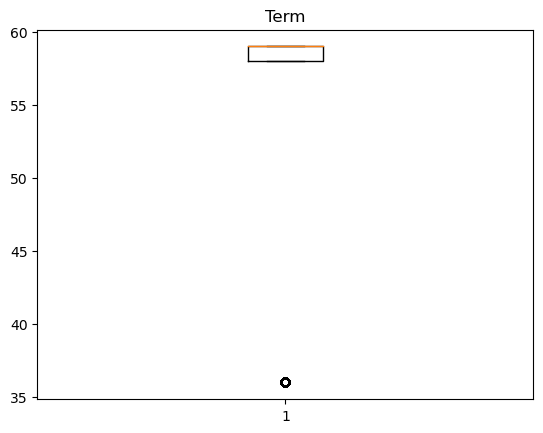

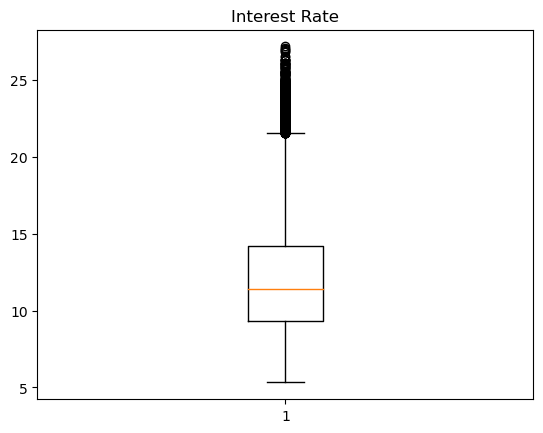

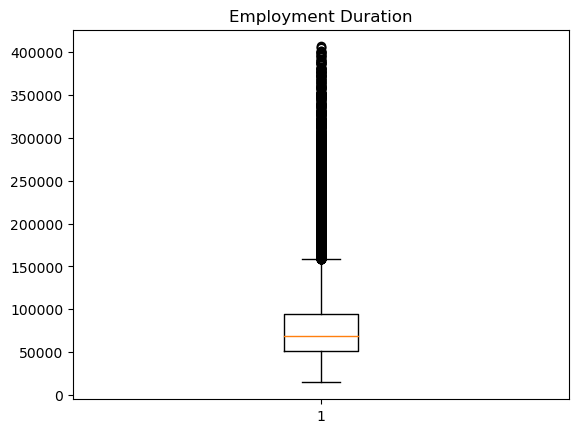

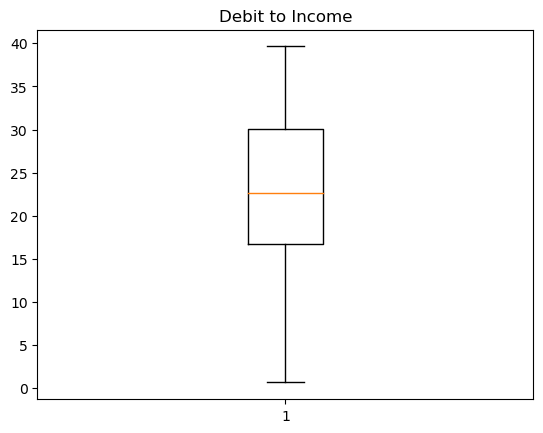

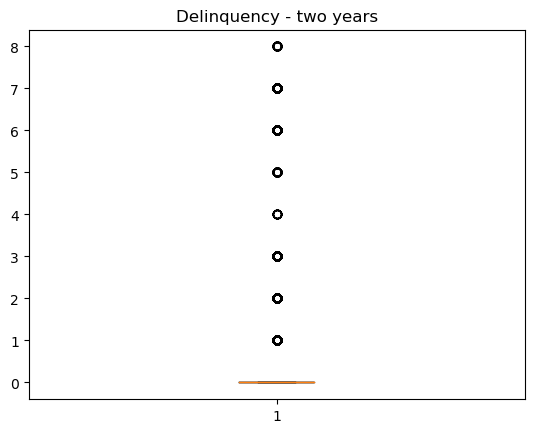

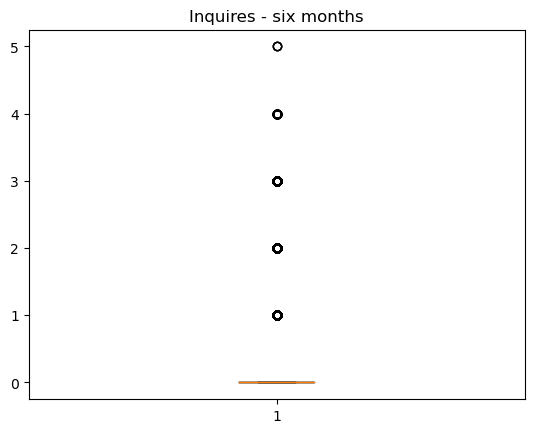

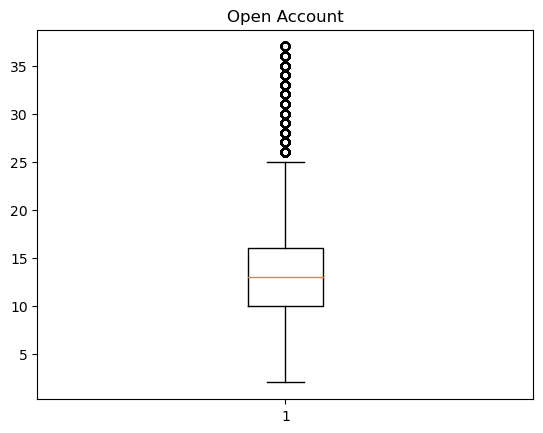

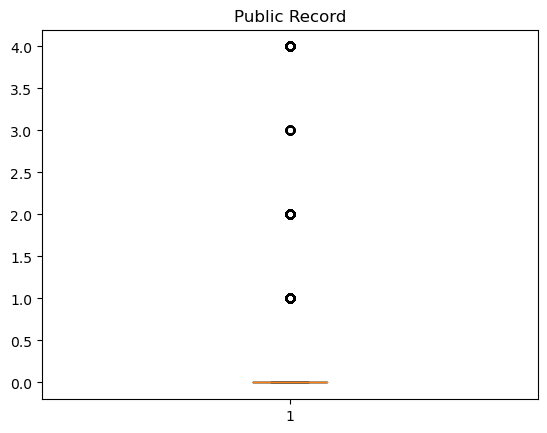

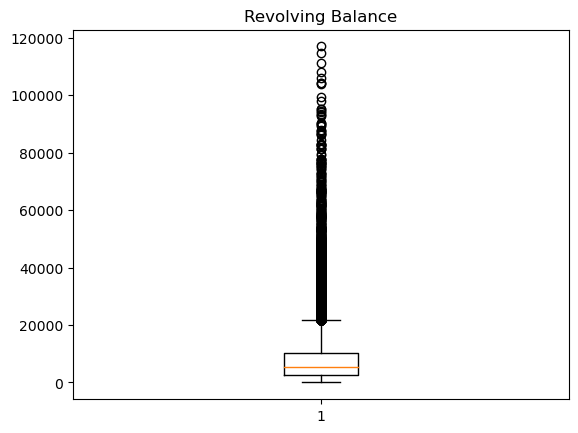

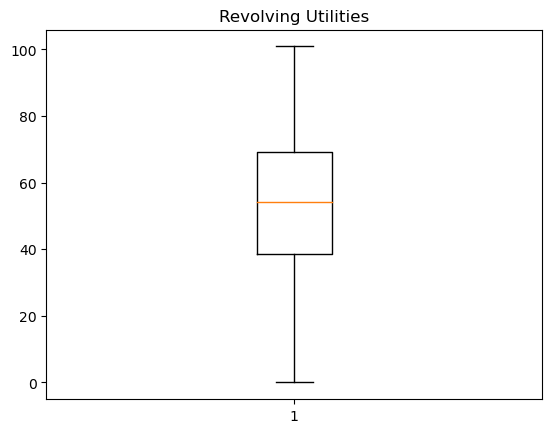

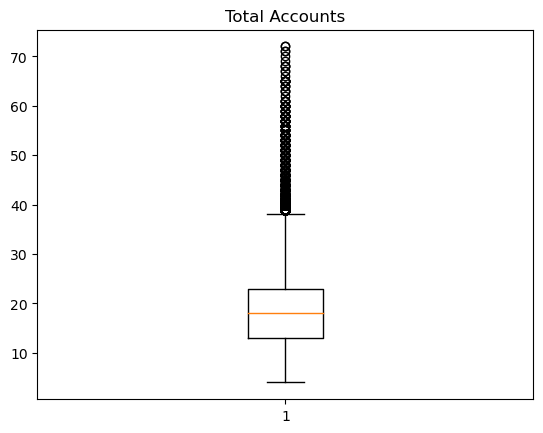

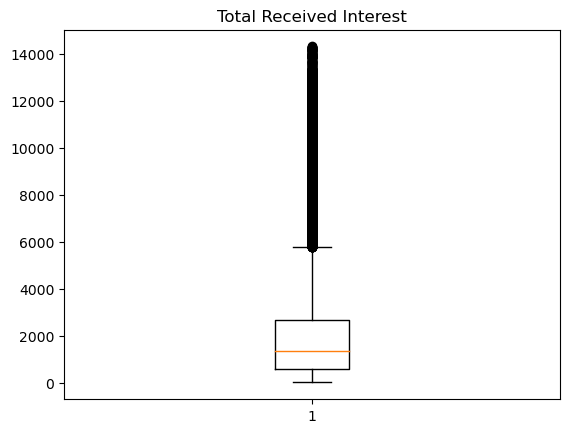

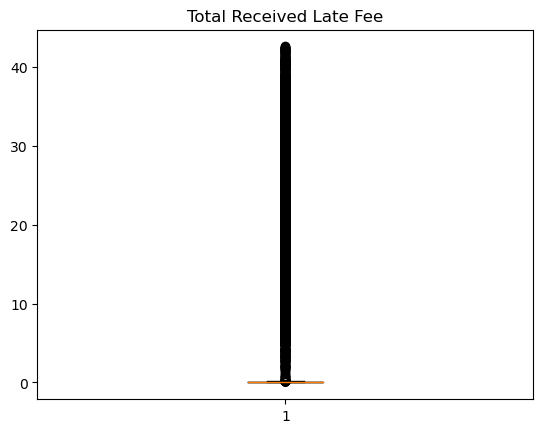

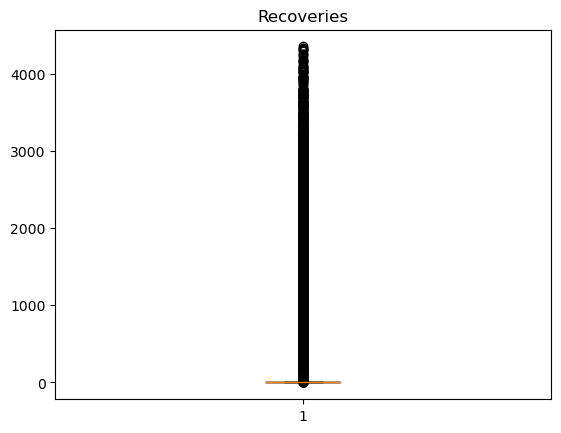

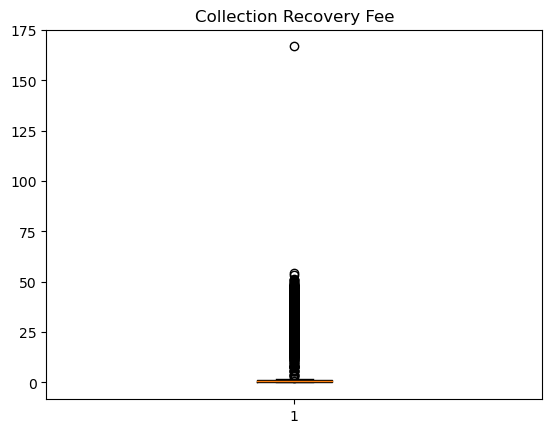

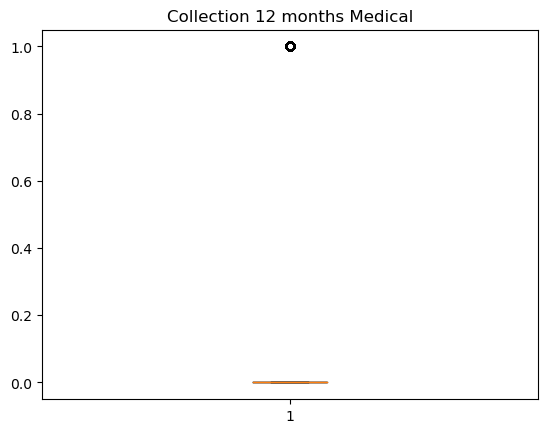

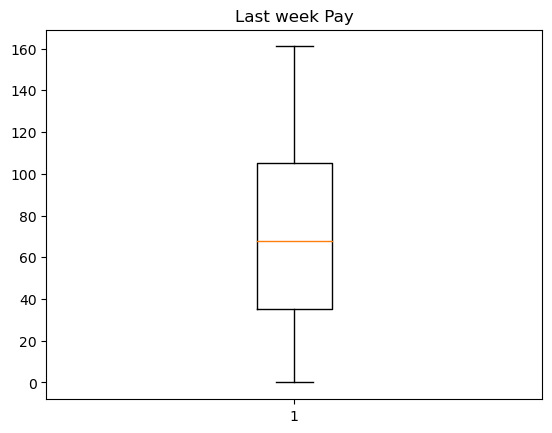

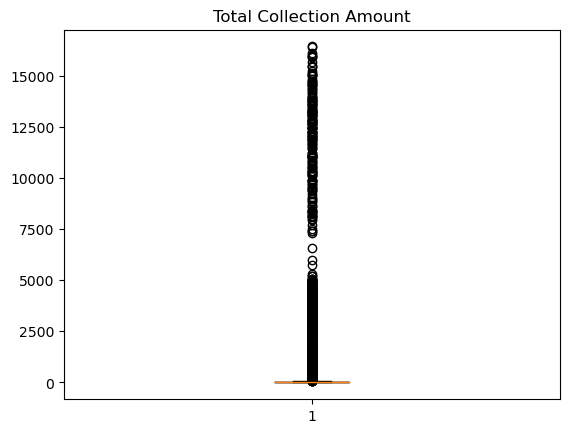

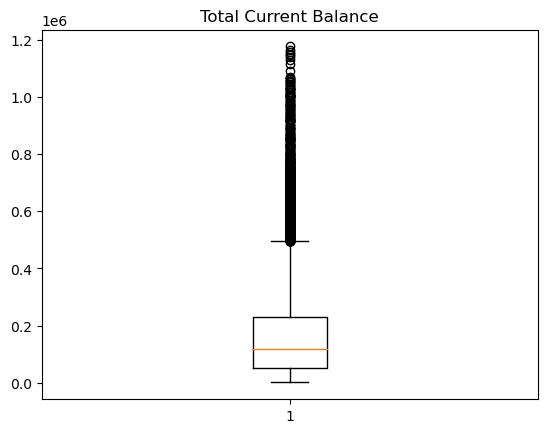

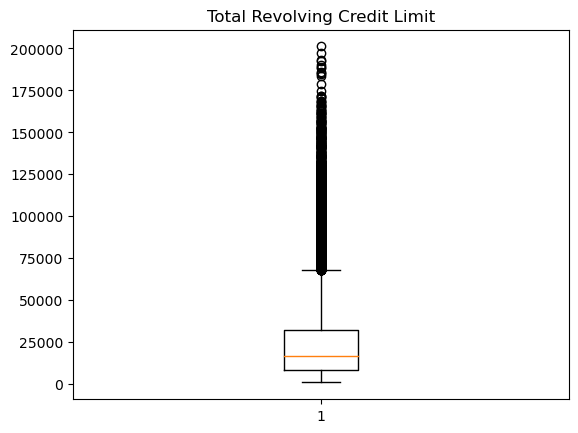

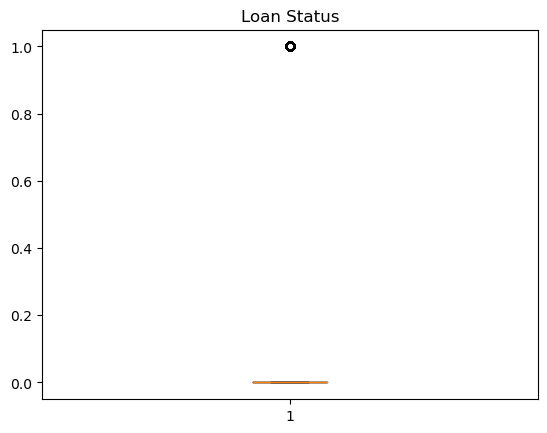

In [14]:
# Do boxplot of numerical columns
for column in numerical_columns:
    plt.boxplot(df[column])
    plt.title(column)
    plt.show()

                              Loan Amount  Funded Amount  \
Loan Amount                      1.000000      -0.000551   
Funded Amount                   -0.000551       1.000000   
Funded Amount Investor           0.002831       0.010227   
Term                             0.004277      -0.001503   
Interest Rate                   -0.004888       0.002310   
Employment Duration              0.016691      -0.003518   
Debit to Income                  0.007959       0.002347   
Delinquency - two years         -0.000469       0.011313   
Inquires - six months            0.008962      -0.001587   
Open Account                     0.009088       0.005755   
Public Record                   -0.002542       0.003750   
Revolving Balance               -0.001738      -0.004485   
Revolving Utilities              0.014828       0.004460   
Total Accounts                  -0.002071       0.008298   
Total Received Interest         -0.001887       0.002759   
Total Received Late Fee         -0.00003

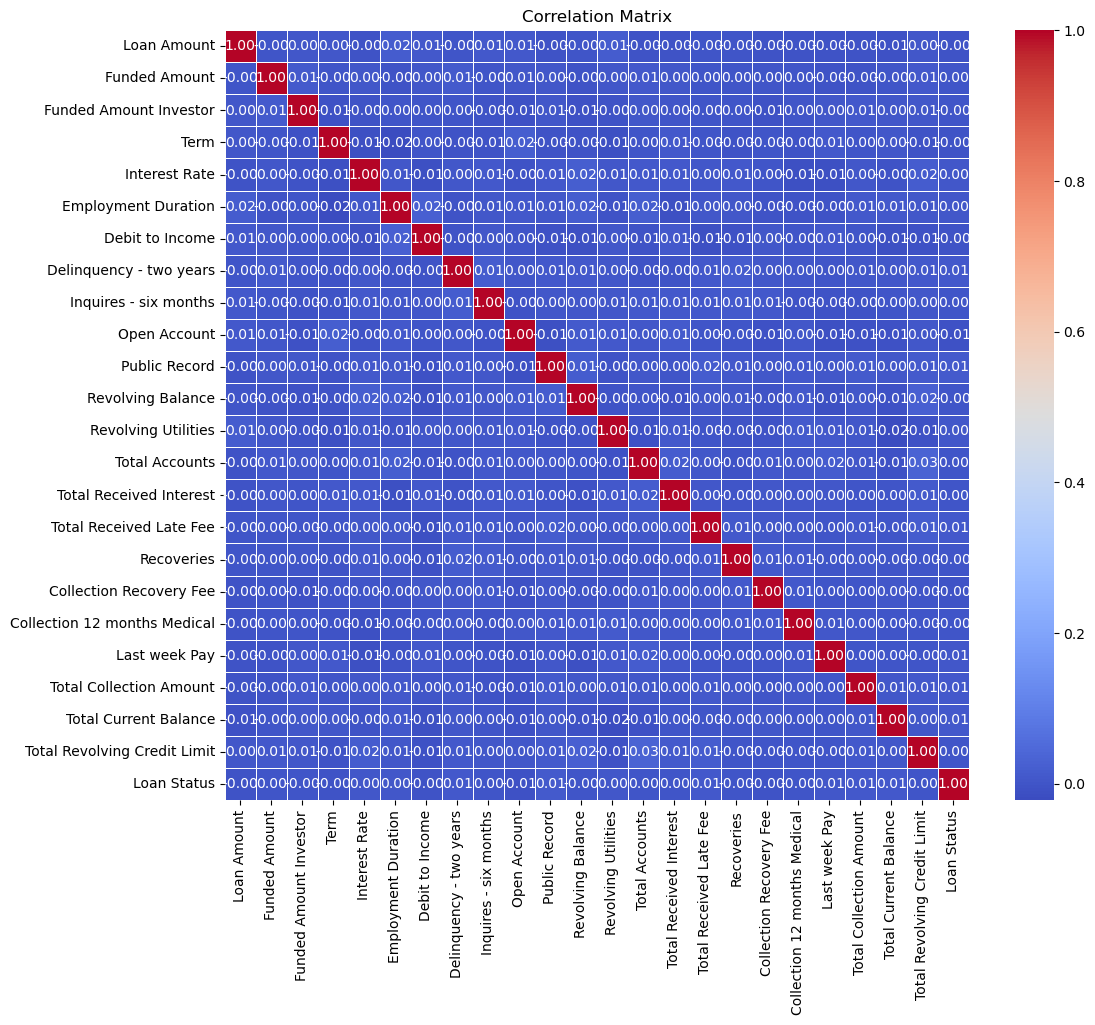

In [15]:
# Let's check the correlation between variables 
correlation_num = df[numerical_columns].corr()
print(correlation_num)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [16]:
# Identify outliers
print(df.shape)
print(df.nunique())

numerical_columns_outliers = [ 'Loan Amount','Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Employment Duration', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit']

for column in numerical_columns_outliers:
    z_scores = zscore(df[column])
    threshold = 2
    outliers = (z_scores > threshold) | (z_scores < -threshold)
    # Handling outliers
    # Removing outliers
    df_no_outliers = df[~outliers]

df = df_no_outliers

print(df.shape)
print(df.nunique())

(67463, 32)
Loan Amount                     27525
Funded Amount                   24548
Funded Amount Investor          67441
Term                                3
Batch Enrolled                     41
Interest Rate                   67448
Grade                               7
Sub Grade                          35
Employment Duration             67454
Home Ownership                      3
Verification Status                 3
Loan Title                         83
Debit to Income                 67454
Delinquency - two years             9
Inquires - six months               6
Open Account                       36
Public Record                       5
Revolving Balance               20582
Revolving Utilities             67458
Total Accounts                     69
Initial List Status                 2
Total Received Interest         67451
Total Received Late Fee         67380
Recoveries                      67387
Collection Recovery Fee         67313
Collection 12 months Medical        2


In [27]:
'''import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target variable
x = df.drop('Loan Status', axis=1)
y = df['Loan Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define numerical and categorical feature columns
numerical_features = x.select_dtypes(include=[np.number]).columns
categorical_features = x.select_dtypes(include=[np.object]).columns

# Create transformers for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', 'onehot', categorical_features)
    ])

# Create a pipeline with random oversampling
oversampling_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Create a pipeline with random undersampling
undersampling_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model with oversampled data
oversampling_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_oversampling = oversampling_pipeline.predict(X_test)

# Print classification report for oversampling
print("Classification Report - Random Oversampling:")
print(classification_report(y_test, y_pred_oversampling))

# Fit the model with undersampled data
undersampling_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_undersampling = undersampling_pipeline.predict(X_test)

# Print classification report for undersampling
print("\nClassification Report - Random Undersampling:")
print(classification_report(y_test, y_pred_undersampling))'''

C:\Users\andre\AppData\Local\Temp\ipykernel_5980\695036848.py:20: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  categorical_features = x.select_dtypes(include=[np.object]).columns


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Data Pre-Processing
# Standardization
# First of all take numerical columns
print(numerical_columns)
# Apply standardization to numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
print(df.describe())


['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Employment Duration', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']
        Loan Amount  Funded Amount  Funded Amount Investor          Term  \
count  6.435900e+04   6.435900e+04            6.435900e+04  6.435900e+04   
mean   1.757616e-16   1.030060e-16            1.915492e-17  4.802531e-17   
std    1.000008e+00   1.000008e+00            1.000008e+00  1.000008e+00   
min   -1.892121e+00  -1.809828e+00           -1.990821e+00 -6.692768e+00   
25%   -8.174583e-01  -7.980295e-01           -7.055819e-01 -5.334895e-02   
50%   -9.273025e-02  -3.3448

In [ ]:
# Normalization
# Apply normalization to numerical columns
minmax_scaler = MinMaxScaler()
df[numerical_columns] = minmax_scaler.fit_transform(df[numerical_columns])
print(df.describe())

        Loan Amount  Funded Amount  Funded Amount Investor          Term  \
count  64359.000000   64359.000000            64359.000000  64359.000000   
mean       0.465836       0.433799                0.398332      0.964208   
std        0.246200       0.239693                0.200086      0.144068   
min        0.000000       0.000000                0.000000      0.000000   
25%        0.264580       0.242519                0.257156      0.956522   
50%        0.443006       0.353627                0.344501      1.000000   
75%        0.620638       0.610843                0.491315      1.000000   
max        1.000000       1.000000                1.000000      1.000000   

       Interest Rate  Employment Duration  Debit to Income  \
count   64359.000000         64359.000000     64359.000000   
mean        0.298243             0.168175         0.580832   
std         0.170069             0.114761         0.217048   
min         0.000000             0.000000         0.000000   
25%  

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
# Apply Label Encoding to the 'Category' column
categorical_columns_encoded = label_encoder.fit_transform(categorical_columns)

# Display the DataFrame after Label Encoding
print("DataFrame after Label Encoding:")
print(categorical_columns_encoded)

# One-Hot Encoding
df_onehot = pd.get_dummies(df, columns=categorical_columns)

# Display the DataFrame after One-Hot Encoding
print("DataFrame after One-Hot Encoding:")
print(df_onehot)

DataFrame after Label Encoding:
[1 2 6 3 7 5 4 0]
DataFrame after One-Hot Encoding:
       Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0         0.264403       0.918699                0.330964   1.0   
1         0.076355       0.321495                0.326910   1.0   
2         0.802154       0.244137                0.604649   1.0   
3         0.298829       0.174783                0.494688   1.0   
4         0.467134       0.359335                0.366690   1.0   
...            ...            ...                     ...   ...   
67457     0.306773       0.490157                0.644860   1.0   
67458     0.370358       0.171664                0.355929   1.0   
67459     0.215059       0.295189                0.428591   1.0   
67460     0.437916       0.938855                0.330967   1.0   
67461     0.457630       0.116551                0.597285   1.0   

       Interest Rate  Employment Duration  Debit to Income  \
0           0.265983             0.412699        

In [ ]:
# See which numerical column interfer more with Loan Status variable
# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Extract the correlation of each variable with the target variable (Loan Status)
loan_status_correlation = correlation_matrix['Loan Status'].sort_values(ascending=False)

# Display the correlations
print(loan_status_correlation)

Loan Status                     1.000000
Total Current Balance           0.011480
Delinquency - two years         0.010513
Public Record                   0.009695
Total Collection Amount         0.008669
Total Received Late Fee         0.008279
Total Revolving Credit Limit    0.005855
Last week Pay                   0.004616
Revolving Utilities             0.004030
Employment Duration             0.003909
Total Received Interest         0.002696
Interest Rate                   0.002327
Inquires - six months           0.001360
Funded Amount Investor          0.000901
Funded Amount                   0.000256
Recoveries                     -0.000287
Total Accounts                 -0.000307
Collection 12 months Medical   -0.000697
Revolving Balance              -0.002457
Debit to Income                -0.003477
Loan Amount                    -0.004459
Collection Recovery Fee        -0.005086
Term                           -0.005547
Open Account                   -0.007346
Name: Loan Statu

In [ ]:
# See which categorical column interfer more with Loan Status variable
# Convert categorical variables to dummy variables
df_dummies = pd.get_dummies(df, columns=categorical_columns)

# Calculate the correlation matrix for dummy variables
dummy_correlation_matrix = df_dummies.corr()

# Extract the correlation of each dummy variable with the target variable (Loan Status)
dummy_loan_status_correlation = dummy_correlation_matrix['Loan Status'].sort_values(ascending=False)

# Display the correlations
print(dummy_loan_status_correlation)

Loan Status                      1.000000
Loan Title_credit card loan      0.013879
Initial List Status_f            0.013821
Loan Title_refi                  0.013793
Loan Title_bills                 0.013509
                                   ...   
Loan Title_debt consolidation   -0.008668
Grade_B                         -0.012016
Sub Grade_C1                    -0.012187
Initial List Status_w           -0.013821
Home Ownership_MORTGAGE         -0.014175
Name: Loan Status, Length: 200, dtype: float64


In [ ]:
# Creation of models using data mining algorithms
# Implement a baseline model to establish a benchmark for performance
# Assume 'Loan Status' is your target variable
X = df.drop('Loan Status', axis=1)
y = df['Loan Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DummyClassifier as the baseline model (predicts the majority class)
baseline_model = DummyClassifier(strategy='most_frequent')

# Train the baseline model
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
baseline_predictions = baseline_model.predict(X_test)

# Evaluate the baseline model
accuracy = accuracy_score(y_test, baseline_predictions)
conf_matrix = confusion_matrix(y_test, baseline_predictions)
classification_rep = classification_report(y_test, baseline_predictions)

# Display the results
print(f'Baseline Model Accuracy: {accuracy:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Baseline Model Accuracy: 0.9058
Confusion Matrix:
[[11659     0]
 [ 1213     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     11659
         1.0       0.00      0.00      0.00      1213

    accuracy                           0.91     12872
   macro avg       0.45      0.50      0.48     12872
weighted avg       0.82      0.91      0.86     12872



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Define categorical and numerical features
categorical_features = ['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership', 'Verification Status', 'Loan Title', 'Initial List Status', 'Application Type']
numerical_features = X.columns.difference(categorical_features)

# Create transformers for preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)
    
    # Display the results
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{classification_rep}')
    print('\n' + '-'*50 + '\n')


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

Model: Logistic Regression
Accuracy: 0.9058
Confusion Matrix:
[[11659     0]
 [ 1213     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     11659
         1.0       0.00      0.00      0.00      1213

    accuracy                           0.91     12872
   macro avg       0.45      0.50      0.48     12872
weighted avg       0.82      0.91      0.86     12872


--------------------------------------------------

Model: Decision Tree
Accuracy: 0.8178
Confusion Matrix:
[[10393  1266]
 [ 1079   134]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     11659
         1.0       0.10      0.11      0.10      1213

    accuracy                           0.82     12872
   macro avg       0.50      0.50      0.50     12872
weighted avg       0.83      0.82      0.82     12872


--------------------------------------------------



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest
Accuracy: 0.9058
Confusion Matrix:
[[11659     0]
 [ 1213     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     11659
         1.0       0.00      0.00      0.00      1213

    accuracy                           0.91     12872
   macro avg       0.45      0.50      0.48     12872
weighted avg       0.82      0.91      0.86     12872


--------------------------------------------------

Model: Gradient Boosting
Accuracy: 0.9056
Confusion Matrix:
[[11656     3]
 [ 1212     1]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     11659
         1.0       0.25      0.00      0.00      1213

    accuracy                           0.91     12872
   macro avg       0.58      0.50      0.48     12872
weighted avg       0.84      0.91      0.86     12872


--------------------------------------------------



In [ ]:
'''
# Utilize ensemble methods like bagging or boosting to improve model performance
# Create a pipeline with the preprocessor and Random Forest classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Perform cross-validation
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {cv_scores.mean():.4f}')
print(f'Standard Deviation of Accuracy: {cv_scores.std():.4f}')
'''

"\n# Utilize ensemble methods like bagging or boosting to improve model performance\n# Create a pipeline with the preprocessor and Random Forest classifier\nrf_pipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('classifier', RandomForestClassifier(random_state=42))\n])\n\n# Perform cross-validation\ncv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')\n\n# Display cross-validation scores\nprint(f'Cross-Validation Scores: {cv_scores}')\nprint(f'Mean Accuracy: {cv_scores.mean():.4f}')\nprint(f'Standard Deviation of Accuracy: {cv_scores.std():.4f}')\n"

In [ ]:
# Create a pipeline with the preprocessor and Gaussian Naive Bayes classifier
gnb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Fit the pipeline on the training data
gnb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
predictions = gnb_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

# Display the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.1032
Confusion Matrix:
[[  138 11521]
 [   22  1191]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.01      0.02     11659
         1.0       0.09      0.98      0.17      1213

    accuracy                           0.10     12872
   macro avg       0.48      0.50      0.10     12872
weighted avg       0.79      0.10      0.04     12872



Performance Metrics for All Features:
Accuracy: 0.1032
Precision: 0.0937
Recall: 0.9819
F1-Score: 0.1711
Confusion Matrix:
[[  138 11521]
 [   22  1191]]
